<a href="https://colab.research.google.com/github/janghwan0113/spine-classification/blob/main/challenge_2016145101_%EC%95%88%EC%9E%A5%ED%99%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Mon Dec 13 17:21:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    38W / 250W |  14533MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install SimpleITK

In [ ]:
import os

import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import scipy.io

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
from torchsummary import summary
from tqdm import tqdm

# Data check

## view_input_dcm_data

Width:  2588
Heigh:  3232
Depth:  1
Dimension:  3
Pixel ID: 3
Pixel ID Type:  16-bit unsigned integer
check
[[[0.06028708 0.06028708 0.06028708]
  [0.06124402 0.06124402 0.06124402]
  [0.05845295 0.05845295 0.05845295]
  ...
  [0.11331739 0.11331739 0.11331739]
  [0.12025518 0.12025518 0.12025518]
  [0.12185008 0.12185008 0.12185008]]

 [[0.06371611 0.06371611 0.06371611]
  [0.06204147 0.06204147 0.06204147]
  [0.05813397 0.05813397 0.05813397]
  ...
  [0.11307815 0.11307815 0.11307815]
  [0.12001595 0.12001595 0.12001595]
  [0.12623605 0.12623605 0.12623605]]

 [[0.06371611 0.06371611 0.06371611]
  [0.06052632 0.06052632 0.06052632]
  [0.0585327  0.0585327  0.0585327 ]
  ...
  [0.11347687 0.11347687 0.11347687]
  [0.11738437 0.11738437 0.11738437]
  [0.12519936 0.12519936 0.12519936]]

 ...

 [[0.14824562 0.14824562 0.14824562]
  [0.14338118 0.14338118 0.14338118]
  [0.13883573 0.13883573 0.13883573]
  ...
  [0.13269538 0.13269538 0.13269538]
  [0.1299043  0.1299043  0.1299043 ]
  [0.

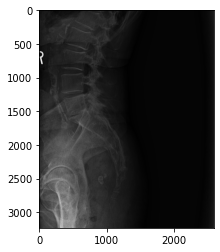

In [ ]:
filename = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train/img/002.dcm'
images = sitk.ReadImage(filename)

print("Width: ",images.GetWidth())
print("Heigh: ",images.GetHeight())
print("Depth: ",images.GetDepth())
print("Dimension: ",images.GetDimension())
print("Pixel ID:",images.GetPixelIDValue())
print("Pixel ID Type: ",images.GetPixelIDTypeAsString())

images_array=sitk.GetArrayFromImage(images).astype('float32')
img=np.squeeze(images_array)
copy_img=img.copy()
min=np.min(copy_img)
max=np.max(copy_img)


#0~1(실수)로 normalize하고 0~255(정수)로 바꿔줌
copy_img1=copy_img-np.min(copy_img)
copy_img=copy_img1/np.max(copy_img1)
# copy_img*=2**8-1
# copy_img=copy_img.astype(np.uint8)

copy_img=np.expand_dims(copy_img,axis=-1)
copy_img=cv2.cvtColor(copy_img,cv2.COLOR_GRAY2RGB)
print("check")

# plt.imshow(copy_img, cmap=plt.cm.bone)
#cv2_imshow(copy_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


plt.imshow(copy_img.squeeze(), cmap='gray')

print(copy_img)
print(copy_img.shape)
#datatype = np.ndarray
print("==================")
print("images_array")
print(type(images_array[0][0][0]))
print(images_array.shape)
print(images_array)
print(np.amin(copy_img))
print(np.amax(copy_img))


## view_label_mat_data

<class 'dict'>
__header__
__version__
__globals__
label_separated
size : (3232, 2588, 7)
datatype: <class 'numpy.uint8'>
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
mat_file_value
0


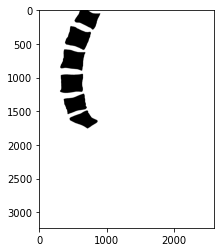

In [ ]:
mat_file_name =  "/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train/label/002.mat"
mat_file = scipy.io.loadmat(mat_file_name)

print(type(mat_file))

for i in mat_file:
    print(i)

mat_file_value = mat_file['label_separated']
print("size :",mat_file_value.shape)
print("datatype:", type(mat_file_value[0][0][0]))

print(mat_file_value[:,:,6])
plt.imshow(mat_file_value[:,:,6],cmap='gray')#plt.cm.bone
mat_file_value[:,:,6] = mat_file_value[:,:,6]*(-1)
#datatype = np.ndarray
print("==================")
print(mat_file_value[:,:,6])
print("mat_file_value")
print(np.amin(mat_file_value[:,:,6]))

# UNet Network

In [ ]:
data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/datasets'
ckpt_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/checkpoint'
log_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/log'
result_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result'
board_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/leaderboard'
test_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test'

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

## U-Net 구조 설계
class UNET(nn.Module):

    # U-Net에서 활용할 기본 block 들을 정의합니다. 
    def __init__(
            self, in_channels=1, out_channels=6, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contractive Path에 필요한 모듈을 self.downs 리스트에 보관합니다. DoubleConv blocks.
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Expansive Path에 필요한 모듈을 self.ups 리스트에 보관합니다. Transpose2d Convolution 및 DoubleConv blocks.
        for feature in reversed(features): #[512, 256, 128, 64]
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        #self.up : [(ConvTransposed2d, DoubleConv) *4]


        # U-Net의 가장 아래 부분.
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # 가장 마지막 Convolution layer. 1x1 Conv. 로 Output channel 을 맞추는 역할. 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    # __init__ 에서 정의한 요소들로 실제 U-Net을 설계.
    def forward(self, x):

        # skip-connection 시킬 feature map 들을 보관하고 있을 리스트.
        skip_connections = []

        for down in self.downs: #self.downs: (DoubleConv *4)
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  #순서 뒤집어줌

        ## self.ups: [(ConvTranspose2D, DoubleConv) x 4]
        for idx in range(0, len(self.ups), 2): ## idx: 0, 2, 4, 6

            # ConvTransposed2d
            x = self.ups[idx](x) 
            skip_connection = skip_connections[idx//2] ## idx//2: 0, 1, 2, 3

            # Resize the upsampled feature map to the size of the skip-connected feature map.
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            
            # DoubleConv
            x = self.ups[idx+1](concat_skip) ## idx+1: 1, 3, 5, 7

        return self.final_conv(x)

In [ ]:
#@title 기본 제목 텍스트
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        #Convolution, Batch norm, ReLU set
        def CBR2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = True):
            #convolution layer
            layers = []
            layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding, bias = bias)]
            #batch norm layer
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            #ReLU layer
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)
            
            return cbr
        
        #contracting path
        self.enc1_1 = CBR2d(in_channels = 1, out_channels = c_a[0] )
        self.enc1_2 = CBR2d(in_channels = c_a[0], out_channels = c_a[0])

        self.pool1 = nn.MaxPool2d(kernel_size = 2)

        self.enc2_1 = CBR2d(in_channels = c_a[0], out_channels = c_a[1])
        self.enc2_2 = CBR2d(in_channels = c_a[1], out_channels = c_a[1])

        self.pool2 = nn.MaxPool2d(kernel_size = 2)

        self.enc3_1 = CBR2d(in_channels = c_a[1] , out_channels = c_a[2])
        self.enc3_2 = CBR2d(in_channels = c_a[2], out_channels = c_a[2])

        self.pool3 = nn.MaxPool2d(kernel_size = 2)

        self.enc4_1 = CBR2d(in_channels = c_a[2], out_channels = c_a[3])
        self.enc4_2 = CBR2d(in_channels = c_a[3], out_channels = c_a[3])

        self.pool4 = nn.MaxPool2d(kernel_size = 2)

        self.enc5_1 = CBR2d(in_channels = c_a[3], out_channels = c_a[4])

        #expansive path
        self.dec5_1 = CBR2d(in_channels= c_a[4] , out_channels = c_a[3])

        self.unpool4 = nn.ConvTranspose2d(in_channels= c_a[3], out_channels = c_a[3] , kernel_size=2 , stride= 2, padding =0 , bias = True)

        self.dec4_2 = CBR2d(in_channels= c_a[3]*2 , out_channels = c_a[3])
        self.dec4_1 = CBR2d(in_channels= c_a[3] , out_channels = c_a[2])

        self.unpool3 = nn.ConvTranspose2d(in_channels = c_a[2] , out_channels = c_a[2] , kernel_size=2 , stride=2 , padding =0 , bias = True)

        self.dec3_2 = CBR2d(in_channels= c_a[2]*2 , out_channels = c_a[2])
        self.dec3_1 = CBR2d(in_channels= c_a[2], out_channels = c_a[1])

        self.unpool2 = nn.ConvTranspose2d(in_channels= c_a[1], out_channels=c_a[1] , kernel_size=2 , stride=2 , padding =0 , bias = True)

        self.dec2_2 = CBR2d(in_channels=2*c_a[1] , out_channels = c_a[1])
        self.dec2_1 = CBR2d(in_channels= c_a[1], out_channels=c_a[0])

        self.unpool1 = nn.ConvTranspose2d(in_channels= c_a[0], out_channels=c_a[0] , kernel_size=2 , stride=2 , padding = 0, bias = True)

        self.dec1_2 = CBR2d(in_channels= 2*c_a[0], out_channels = c_a[0])
        self.dec1_1 = CBR2d(in_channels= c_a[0], out_channels= c_a[0])

        self.fc = nn.Conv2d(in_channels= c_a[0], out_channels= 6, kernel_size=1 , stride=1 , padding =0 , bias = True)
    
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.fc(dec1_1)

        return x

# Dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform

        if self.data_dir == '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test':
            lst_input = os.listdir(os.path.join(self.data_dir,'img'))
            lst_label = os.listdir(os.path.join(self.data_dir, 'img'))

            lst_input.sort()
            lst_label.sort()

            self.lst_input = lst_input
            self.lst_label = lst_label
        else:
            lst_input = os.listdir(os.path.join(self.data_dir,'img'))
            lst_label = os.listdir(os.path.join(self.data_dir, 'label'))

            lst_input.sort()
            lst_label.sort()

            self.lst_input = lst_input
            self.lst_label = lst_label

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        
        #testset 일 경우
        if self.data_dir == '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test':
            #label은 없어야하지만 dataset을 구성해주기 위해 input을 복사해주어 structure만 만들어줌.
            
            #absolute path of img and label
            input_abs_path = os.path.join(*[self.data_dir, 'img', self.lst_input[index]])
            label_abs_path = os.path.join(*[self.data_dir, 'img', self.lst_input[index]])
            
           #np.ndarray of img
            images = sitk.ReadImage(input_abs_path)
            input_np =sitk.GetArrayFromImage(images).astype('float32')
            input_np_copy = input_np.copy()

            #input array를 0~1 float 로 바꿔줌
            input_np_copy1 = input_np_copy - np.min(input_np_copy)
            input_np_copy = input_np_copy1 / np.max(input_np_copy1)

            #false np.darray of label            
            label_np =sitk.GetArrayFromImage(images).astype('float32')

            
            data = {'input' : input_np_copy, 'label' : label_np}

            if self.transform:
                data = self.transform(data)

            return data 

        #train, validation set 일 경우
        else:
        
            #absolute path of img and label
            input_abs_path = os.path.join(*[self.data_dir, 'img', self.lst_input[index]])
            label_abs_path = os.path.join(*[self.data_dir, 'label', self.lst_label[index]])
            
            #np.ndarray of img and label
            images = sitk.ReadImage(input_abs_path)
            input_np =sitk.GetArrayFromImage(images).astype('float32')
            input_np_copy = input_np.copy()

            #input array를 0~1 float 로 바꿔줌
            input_np_copy1 = input_np_copy - np.min(input_np_copy)
            input_np_copy = input_np_copy1 / np.max(input_np_copy1)

            #label numpy array
            label_mat_file = scipy.io.loadmat(label_abs_path)
            label_np = label_mat_file['label_separated']

            label = label_np.transpose(2,0,1)[:6,:,:].copy()
            # label[6] = -label[6]+1

            #data['input'] = 0~1 float32 , data['label'] = 0~1 float32
            data = {'input' : input_np_copy, 'label' : label.astype('float32')}

            if self.transform:
                data = self.transform(data)

            return data        

## Dataset example

IndexError: ignored

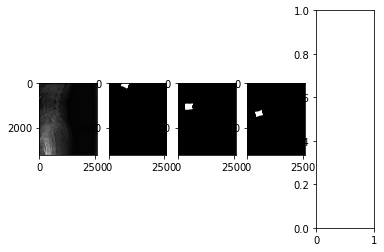

In [ ]:
example = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train')

# print(example.lst_input)
# for name in example.lst_input:
#     print(name[:-3])
#     break
# print(example.lst_input.pop(0)[:-3])

data = example.__getitem__(1)

input = data['input']
label = data['label']

# input = cv2.resize(input.transpose(1,2,0), (2048,2048)) 
# label = cv2.resize(label.transpose(1,2,0), (2048,2048)) 

# print(input.shape)
# print(input[0])
# print(label.shape)
# print(label[6])
# print(type(np.amax(label[6])))
# print(type(np.amax(input[0])))




# print(input.transpose(2,0,1).shape)
# print(input.transpose(1,2,0).shape)
# plt.imshow(input.transpose(2,0,1), cmap='gray')


plt.subplot(151)
plt.imshow(input.squeeze(), cmap='gray')

plt.subplot(152)
plt.imshow(label[0], cmap='gray')
plt.subplot(153)
plt.imshow(label[3], cmap='gray')
plt.subplot(154)
plt.imshow(label[4], cmap='gray')
plt.subplot(155)
plt.imshow(label[6], cmap='gray')


# Data transformer

In [ ]:
class ToTensor(object):
    def __call__(self,data):
        label, input = data['label'], data['input']

        input = input.astype(np.float32)
        label = label.astype(np.float32)
        
        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean = 0.5, std = 0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std
        data = {'label': label, 'input' : input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label':label, 'input':input}

        return data

class Rescale(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        # h, w = label.shape[1], label.shape[2]
        
        # small_val = h if h <= w else w
        
        # exp = 0

        # while small_val>=1:
        #     small_val = small_val / 2
        #     exp += 1
        
        # resize = 2**(exp-1)

        input = cv2.resize(input.transpose(1,2,0), (1024,1024)) 
        label = cv2.resize(label.transpose(1,2,0), (1024,1024))
  
        data = {'label':label.transpose(2,0,1), 'input':input}

        return data

class Rescale_testset(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        # h, w = label.shape[1], label.shape[2]
        
        # small_val = h if h <= w else w
        
        # exp = 0

        # while small_val>=1:
        #     small_val = small_val / 2
        #     exp += 1
        
        # resize = 2**(exp-1)

        input = cv2.resize(input.transpose(1,2,0), (1024,1024)) 
        label = cv2.resize(label.transpose(1,2,0), (1024,1024))
  
        data = {'label':label, 'input':input}

        return data        

## Data transform example

In [ ]:
#compose transform
transform_example_trainset = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation((-72,72)),
    # transforms.RandomAffine(0,translate=(0.1,0.1)),
    Normalization(mean=0.5, std=0.5),
    RandomFlip(),
    # Rescale(),
    ToTensor()
])

transform_exmaple_testset = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation((-72,72)),
    # transforms.RandomAffine(0,translate=(0.1,0.1)),
    Normalization(),
    # RandomFlip(),
    ToTensor()
])

=========input==========
torch.Size([2048, 2048])
<class 'torch.Tensor'>
tensor([[23.1549, 23.0506, 22.4809,  ..., 28.1161, 28.6763, 29.1965],
        [23.3534, 23.0108, 22.4393,  ..., 28.3407, 28.5373, 29.3542],
        [24.0697, 23.0865, 22.4852,  ..., 28.4495, 28.5158, 29.1485],
        ...,
        [32.5115, 31.9423, 31.3404,  ..., 29.5181, 29.3880, 29.4674],
        [31.5061, 30.9562, 30.3015,  ..., 30.1901, 30.0526, 29.9397],
        [29.9773, 29.9616, 29.4195,  ..., 30.3305, 30.5096, 30.3370]])
=========label==========
torch.Size([6, 2048, 2048])
<class 'torch.Tensor'>
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 

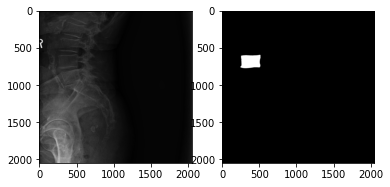

In [ ]:
dataset_db = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train', transform=transform_example_trainset)
data = dataset_db.__getitem__(1)

input = data['input']
label = data['label']

print("=========input==========")
print(input.shape)
print(type(input))
print(input)
print("=========label==========")
print(label.shape)
print(type(label))
print(label)
print("===================")
plt.subplot(121)
plt.imshow(input.squeeze(), cmap='gray')

plt.subplot(122)
plt.imshow(label[2], cmap='gray')

# Trainer

In [ ]:
lr = 1e-3
batch_size = 2
num_epoch = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

class trainer:

    def __init__(self, model, train_loader, opt, epoch_size = num_epoch, learning_rate = lr, use_cuda =True):
        
        self.use_cuda = use_cuda

        #Use GPU, model to GPU
        if self.use_cuda:
            self.net = model.cuda()

        else:
            self.net = model
    
        self.train_loader = train_loader
        self.optimizer = opt
        self.epoch_size = epoch_size
        self.learning_rate = learning_rate
        self.criterion = nn.BCEWithLogitsLoss().to(device)
        # self.criterion = nn.CrossEntropyLoss().to(device)

        self.history = {'train_acc':[],'val_acc':[],'test_acc':[],'train_loss':[],'val_loss':[],'test_loss':[]}

    def train(self, validation_loader = None):

        #Choose optimizer
        if self.optimizer == "SGD":
          optimizer = torch.optim.SGD(self.net.parameters(), lr = self.learning_rate)
        elif self.optimizer == "Adam":
          optimizer = torch.optim.Adam(self.net.parameters(), lr = self.learning_rate)
        elif self.optimizer == "Adagrad":
          optimizer = torch.optim.Adagrad(self.net.parameters(), lr = self.learning_rate)
        elif self.optimizer == "RMSprop":
          optimizer = torch.optim.RMSprop(self.net.parameters(), lr = self.learning_rate)

        for epoch in tqdm(range(self.epoch_size)):
            
            self.net.train()
            loss_arr = []

            for batch, data in enumerate(self.train_loader):
                
                #forward pass
                if self.use_cuda:
                    input = data['input'].to(device)
                    label = data['label'].to(device)

                #unsqueeze depends on batch size to match shape
                if batch_size ==1:
                    output = self.net(input)
                else:
                    output = self.net(input.unsqueeze(1))

                preds = output.clone()
                
                for i in range(output.shape[0]):
                    for j in range(output.shape[1]):
                        preds[i][j] = (output[i][j]-torch.mean(output[i][j]))/torch.std(output[i][j])
                        preds[i][j] = torch.sigmoid(output[i][j])

                output = preds.clone()
                #backward pass & loss
                optimizer.zero_grad() #gradient initialization

                loss = self.criterion(output, label) #output:prediction, label: answer tensor
                loss.backward() #backpropagation
                optimizer.step()
                
                #history
                loss_arr += [loss.item()]
                
                print("Train: epoch %04d / %04d | batch %04d / %04d | loss %.4f" % (epoch+1, self.epoch_size, batch, num_batch_train, np.mean(loss_arr)))
                
                #tensor board
            #     print(label.shape)
            #     label = fn_tonumpy(label)
            #     input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            #     output = fn_tonumpy(fn_class(output))

            #     writer_train.add_image('label', label, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
            #     writer_train.add_image('input', input, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
            #     writer_train.add_image('output', output, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
            

            # writer_train.add_scalar('loss', np.mean(loss_arr), epoch)
            self.history['train_loss'].append(np.mean(loss_arr))

            if validation_loader != None:
                self.validate(validation_loader)

            save(ckpt_dir = ckpt_dir, net = self.net, optim = optimizer, epoch = epoch)
                ############################


    @torch.no_grad()
    def validate(self, data_loader):
        
        self.net.eval() #no weight update
        val_loss_arr = []
        
        num_correct = 0
        num_pixels = 0
        

        for batch, data in enumerate(data_loader):
            #forward pass
            if self.use_cuda:
                input = data['input'].to(device)
                label = data['label'].to(device)
            
            #unsqueeze depends on batch size to match shape
            if batch_size ==1:
                output = self.net(input)
            else:
                output = self.net(input.unsqueeze(1))
            
            #loss function
            val_loss = self.criterion(output, label)
            val_loss_arr += [val_loss.item()]

            print("Val loss %.4f" % (np.mean(val_loss_arr)))
            
            #dice loss
            for j in range(output.shape[0]):
                output = torch.clone(output[j]) #(N, 6, 1024,1024)

                for i in range(output.shape[0]):
                    output[i] = (output[i]-torch.mean(output[i]))/torch.std(output[i])
                    output[i] = torch.sigmoid(output[i])
                    output[i] = fn_classifier(output[i])
            
            num_correct += (output == label).sum()
            num_pixels += torch.numel(output)
            
            dice_score = (2*(num_correct).sum()) / ((output+label).sum() + 1e-8)

            print(f"Dice score : {dice_score}")

        #     #tensor board
        #     label = fn_tonumpy(label)
        #     input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        #     output = fn_tonumpy(fn_class(output))

        #     writer_val.add_image('label', label, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
        #     writer_val.add_image('input', input, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')
        #     writer_val.add_image('output', output, num_batch_train * (epoch-1)+batch, dataformats ='NHWC')

        # writer_val.add_scalar('loss', np.mean(val_loss_arr), epoch)

        if  data_loader != self.train_loader: 
            self.history['val_loss'].append(np.mean(val_loss_arr))


    @torch.no_grad()
    def test(self, data_loader):
        
        test_img_arr = os.listdir(os.path.join(test_dir,'img'))
        test_img_arr.sort()
            
        self.net.eval() #no weight update
        test_loss_arr = []

        for batch, data in enumerate(data_loader):
            #forward pass
            if self.use_cuda:
                input = data['input'].to(device)
                # label = data['label'].to(device)

            #unsqueeze depends on batch size to match shape
            if batch_size ==1:
                output = self.net(input)
            else:
                output = self.net(input.unsqueeze(1))
            
            #######################################
            ###there is no backward pass in test###
            #######################################

            #loss function
            # test_loss = self.criterion(output, label)

            # test_loss_arr += [test_loss.item()]

            #print test loss
            # print("Test:  batch %04d / %04d | loss %.4f" % (batch, num_batch_test, np.mean(test_loss_arr)))

            #tensor board
            # label = fn_tonumpy(label)


            #save output image and numpy 
            
            input = fn_denorm(input, mean=0.5, std=0.5)
            input = fn_tonumpy(input)

            # print(type(input)) #<class 'torch.Tensor'>
            # print(type(output)) #<class 'torch.Tensor'>

            # output = fn_tonumpy(fn_classifier(output))
            # output = fn_tonumpy(output)

            # print(f"input: {type(input)} : {input.shape}") #(4, 1024, 1024)
            # print(f"output: {type(output)} : {output.shape}") #(4, 6, 1024, 1024)
            print(1)
            for j in range(output.shape[0]):
                
                id = num_batch_test * (batch -1)+j
                print(2)
                # plt.imsave(os.path.join(result_dir, 'png' ,'label_%04d.png' %id), label[j].squeeze(), cmap='gray')
                plt.imsave(os.path.join(result_dir, 'png' ,'input_%04d.png' %id), input[j].squeeze(), cmap='gray')


                print(3)
                preds = output[j].clone()  # (6,1024,1024)
                for i in range(preds.shape[0]):
                    preds[i] = (preds[i]-torch.mean(preds[i]))/torch.std(preds[i])
                    preds[i] = torch.sigmoid(preds[i])
                    preds[i] = fn_classifier(preds[i])
                
                preds = fn_tonumpy(preds)
                np.save(os.path.join(result_dir, 'numpy','output_%04d.npy' %id), preds.squeeze())
                print(4)

                # output_ = fn_tonumpy(fn_classifier(output))
                preds_torch = torch.Tensor(preds)
                print(5)
                for k in range(6):
                    plt.imsave(os.path.join(result_dir, 'png' ,'output_%04d_%04d.png' %(id, k)), preds[k].squeeze(), cmap='gray')

                # print(f"input shape {input[j].squeeze().shape}") #(1024, 1024)
                # print(f"output shape {output[j].squeeze().shape}") #(6, 1024, 1024)
                
                # np.save(os.path.join(result_dir, 'numpy','label_%04d.npy' %id), label[j].squeeze())
                
                # np.save(os.path.join(result_dir, 'numpy','input_%04d.npy' %id), input[j].squeeze())
                # np.save(os.path.join(result_dir, 'numpy','output_%04d.npy' %id), output[j].squeeze())
                



                if test_img_arr:
                    print(test_img_arr)
                    test_input_abs_path = os.path.join(test_dir, 'img', test_img_arr[0])
                    images = sitk.ReadImage(test_input_abs_path)
                    test_input_shape =sitk.GetArrayFromImage(images).shape #(1,3232,2588)

                    print(test_input_shape)
                    print(output.shape) #(2,6,1024,1024)
                    print(output[j].shape) #(6,1024,1024)
                    # 7 채널로..
                    preds_tensor = torch.cat((preds_torch, preds_torch[5].unsqueeze(0)))
                    preds_np = cv2.resize(fn_tonumpy(preds_tensor).transpose(1,2,0), (test_input_shape[2],test_input_shape[1])) 
                    
                    print(np.amax(preds_np))
                    #7채널
                    # output_np = cv2.resize(fn_tonumpy(output[j]).transpose(1,2,0), (test_input_shape[2],test_input_shape[1])) 
                    
                    print(preds_np.shape)

                    
                    #preds save
                    np.save(os.path.join(board_dir, test_img_arr.pop(0)[:-4]), np.uint8(preds_np))

                    #output save
                    # np.save(os.path.join(board_dir, test_img_arr.pop(0)[:-4]), np.uint8(output_np))
                
                
        self.history['test_loss'].append(np.mean(test_loss_arr))

        # print("Average test: loss %.4f" % (np.mean(test_loss_arr)))



# Data transform

In [ ]:
#compose transform
transform_wholeset = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation((-72,72)),
    # transforms.RandomAffine(0,translate=(0.1,0.1)),
    Normalization(),
    RandomFlip(),
    Rescale(),
    ToTensor()
])

transform_testset = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation((-72,72)),
    # transforms.RandomAffine(0,translate=(0.1,0.1)),
    Normalization(),
    # RandomFlip(),
    Rescale_testset(),
    ToTensor()
])

#train, val dataset, dataloader
whole_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/train', transform = transform_wholeset)
train_dataset, val_dataset = torch.utils.data.random_split(whole_dataset, [100, 20])
test_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test' , transform = transform_testset)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

In [ ]:
# print(len(test_dataset))
# print(test_dataset.lst_input[0])
# print(test_dataset.lst_label)
# # aaa = test_dataset.__getitem__(1)
# # aaa['input']
# print(len(test_loader.dataset))


# for batch, data in enumerate(test_loader):
#     print(data['input'].shape)

#     print(data['input'])
    
#     print(data['input'].unsqueeze(1).shape)
    
#     print(data['input'].unsqueeze(1))

#     break
#     # #forward pass
    # if self.use_cuda:
    #     input = data['input'].to(device)
    #     label = data['label'].to(device)

    # output = self.net(input.unsqueeze(1))

# Before Train

In [ ]:
#other variables
num_data_train = len(train_dataset)
num_data_val = len(val_dataset)
num_data_test = len(test_dataset)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)
num_batch_test = np.ceil(num_data_test / batch_size)


# 기타 function 설정
# fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_tonumpy = lambda x : x.to('cpu').detach().numpy() # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_denorm = lambda x, mean, std : (x * std) + mean 
fn_classifier = lambda x :  1.0 * (x > 0.65)  # threshold 0.5 기준으로 indicator function으로 classifier 구현

# tensorboard, SummaryWriter
writer_train = SummaryWriter(log_dir = os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir, 'val'))

#save network
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

#load network
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch


## example model summary

In [ ]:
example_model = UNET()
example_model.cuda()

summary(example_model, input_size=(1,1024,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]             576
       BatchNorm2d-2       [-1, 64, 1024, 1024]             128
              ReLU-3       [-1, 64, 1024, 1024]               0
            Conv2d-4       [-1, 64, 1024, 1024]          36,864
       BatchNorm2d-5       [-1, 64, 1024, 1024]             128
              ReLU-6       [-1, 64, 1024, 1024]               0
        DoubleConv-7       [-1, 64, 1024, 1024]               0
         MaxPool2d-8         [-1, 64, 512, 512]               0
            Conv2d-9        [-1, 128, 512, 512]          73,728
      BatchNorm2d-10        [-1, 128, 512, 512]             256
             ReLU-11        [-1, 128, 512, 512]               0
           Conv2d-12        [-1, 128, 512, 512]         147,456
      BatchNorm2d-13        [-1, 128, 512, 512]             256
             ReLU-14        [-1, 128, 5

In [ ]:
example_model_64 = UNet()
example_model_64.cuda()

summary(example_model_64, input_size=(1,1024,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]             640
       BatchNorm2d-2       [-1, 64, 1024, 1024]             128
              ReLU-3       [-1, 64, 1024, 1024]               0
            Conv2d-4       [-1, 64, 1024, 1024]          36,928
       BatchNorm2d-5       [-1, 64, 1024, 1024]             128
              ReLU-6       [-1, 64, 1024, 1024]               0
         MaxPool2d-7         [-1, 64, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]          73,856
       BatchNorm2d-9        [-1, 128, 512, 512]             256
             ReLU-10        [-1, 128, 512, 512]               0
           Conv2d-11        [-1, 128, 512, 512]         147,584
      BatchNorm2d-12        [-1, 128, 512, 512]             256
             ReLU-13        [-1, 128, 512, 512]               0
        MaxPool2d-14        [-1, 128, 2

In [ ]:
example_model_32 = UNet()
example_model_32.cuda()

summary(example_model_32, input_size=(1,1024,1024))

torch.Size([2, 256, 128, 128]) torch.Size([2, 256, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             320
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
              ReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
              ReLU-6       [-1, 32, 1024, 1024]               0
         MaxPool2d-7         [-1, 32, 512, 512]               0
            Conv2d-8         [-1, 64, 512, 512]          18,496
       BatchNorm2d-9         [-1, 64, 512, 512]             128
             ReLU-10         [-1, 64, 512, 512]               0
           Conv2d-11         [-1, 64, 512, 512]          36,928
      BatchNorm2d-12         [-1, 64, 512, 512]             128
             ReLU-13         [-1, 64, 512

# Train

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
Spine_segment = UNET()
Spine_segment.cuda()
trainer_Spine_segment = trainer(Spine_segment, train_loader,"Adam", epoch_size=20, learning_rate=0.001)
trainer_Spine_segment.train(val_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Train: epoch 0001 / 0020 | batch 0000 / 0050 | loss 0.9744
Train: epoch 0001 / 0020 | batch 0001 / 0050 | loss 0.9702
Train: epoch 0001 / 0020 | batch 0002 / 0050 | loss 0.9644
Train: epoch 0001 / 0020 | batch 0003 / 0050 | loss 0.9591
Train: epoch 0001 / 0020 | batch 0004 / 0050 | loss 0.9536
Train: epoch 0001 / 0020 | batch 0005 / 0050 | loss 0.9487
Train: epoch 0001 / 0020 | batch 0006 / 0050 | loss 0.9444
Train: epoch 0001 / 0020 | batch 0007 / 0050 | loss 0.9405
Train: epoch 0001 / 0020 | batch 0008 / 0050 | loss 0.9370
Train: epoch 0001 / 0020 | batch 0009 / 0050 | loss 0.9341
Train: epoch 0001 / 0020 | batch 0010 / 0050 | loss 0.9312
Train: epoch 0001 / 0020 | batch 0011 / 0050 | loss 0.9287
Train: epoch 0001 / 0020 | batch 0012 / 0050 | loss 0.9261
Train: epoch 0001 / 0020 | batch 0013 / 0050 | loss 0.9237
Train: epoch 0001 / 0020 | batch 0014 / 0050 | loss 0.9213
Train: epoch 0001 / 0020 | batch 0015 / 0050 | loss 0.9191
Train: epoch 0001 / 0020 | batch 0016 / 0050 | loss 0.91

  5%|▌         | 1/20 [01:16<24:18, 76.74s/it]

Train: epoch 0002 / 0020 | batch 0000 / 0050 | loss 0.7891
Train: epoch 0002 / 0020 | batch 0001 / 0050 | loss 0.7900
Train: epoch 0002 / 0020 | batch 0002 / 0050 | loss 0.7889
Train: epoch 0002 / 0020 | batch 0003 / 0050 | loss 0.7876
Train: epoch 0002 / 0020 | batch 0004 / 0050 | loss 0.7863
Train: epoch 0002 / 0020 | batch 0005 / 0050 | loss 0.7846
Train: epoch 0002 / 0020 | batch 0006 / 0050 | loss 0.7834
Train: epoch 0002 / 0020 | batch 0007 / 0050 | loss 0.7821
Train: epoch 0002 / 0020 | batch 0008 / 0050 | loss 0.7809
Train: epoch 0002 / 0020 | batch 0009 / 0050 | loss 0.7797
Train: epoch 0002 / 0020 | batch 0010 / 0050 | loss 0.7788
Train: epoch 0002 / 0020 | batch 0011 / 0050 | loss 0.7778
Train: epoch 0002 / 0020 | batch 0012 / 0050 | loss 0.7767
Train: epoch 0002 / 0020 | batch 0013 / 0050 | loss 0.7758
Train: epoch 0002 / 0020 | batch 0014 / 0050 | loss 0.7748
Train: epoch 0002 / 0020 | batch 0015 / 0050 | loss 0.7738
Train: epoch 0002 / 0020 | batch 0016 / 0050 | loss 0.77

 10%|█         | 2/20 [02:32<22:51, 76.19s/it]

Train: epoch 0003 / 0020 | batch 0000 / 0050 | loss 0.7231
Train: epoch 0003 / 0020 | batch 0001 / 0050 | loss 0.7229
Train: epoch 0003 / 0020 | batch 0002 / 0050 | loss 0.7225
Train: epoch 0003 / 0020 | batch 0003 / 0050 | loss 0.7221
Train: epoch 0003 / 0020 | batch 0004 / 0050 | loss 0.7218
Train: epoch 0003 / 0020 | batch 0005 / 0050 | loss 0.7215
Train: epoch 0003 / 0020 | batch 0006 / 0050 | loss 0.7212
Train: epoch 0003 / 0020 | batch 0007 / 0050 | loss 0.7209
Train: epoch 0003 / 0020 | batch 0008 / 0050 | loss 0.7206
Train: epoch 0003 / 0020 | batch 0009 / 0050 | loss 0.7203
Train: epoch 0003 / 0020 | batch 0010 / 0050 | loss 0.7200
Train: epoch 0003 / 0020 | batch 0011 / 0050 | loss 0.7198
Train: epoch 0003 / 0020 | batch 0012 / 0050 | loss 0.7196
Train: epoch 0003 / 0020 | batch 0013 / 0050 | loss 0.7193
Train: epoch 0003 / 0020 | batch 0014 / 0050 | loss 0.7191
Train: epoch 0003 / 0020 | batch 0015 / 0050 | loss 0.7188
Train: epoch 0003 / 0020 | batch 0016 / 0050 | loss 0.71

 15%|█▌        | 3/20 [03:48<21:36, 76.24s/it]

Train: epoch 0004 / 0020 | batch 0000 / 0050 | loss 0.7054
Train: epoch 0004 / 0020 | batch 0001 / 0050 | loss 0.7054
Train: epoch 0004 / 0020 | batch 0002 / 0050 | loss 0.7054
Train: epoch 0004 / 0020 | batch 0003 / 0050 | loss 0.7053
Train: epoch 0004 / 0020 | batch 0004 / 0050 | loss 0.7053
Train: epoch 0004 / 0020 | batch 0005 / 0050 | loss 0.7052
Train: epoch 0004 / 0020 | batch 0006 / 0050 | loss 0.7051
Train: epoch 0004 / 0020 | batch 0007 / 0050 | loss 0.7050
Train: epoch 0004 / 0020 | batch 0008 / 0050 | loss 0.7050
Train: epoch 0004 / 0020 | batch 0009 / 0050 | loss 0.7049
Train: epoch 0004 / 0020 | batch 0010 / 0050 | loss 0.7048
Train: epoch 0004 / 0020 | batch 0011 / 0050 | loss 0.7047
Train: epoch 0004 / 0020 | batch 0012 / 0050 | loss 0.7047
Train: epoch 0004 / 0020 | batch 0013 / 0050 | loss 0.7046
Train: epoch 0004 / 0020 | batch 0014 / 0050 | loss 0.7045
Train: epoch 0004 / 0020 | batch 0015 / 0050 | loss 0.7045
Train: epoch 0004 / 0020 | batch 0016 / 0050 | loss 0.70

 20%|██        | 4/20 [05:04<20:19, 76.20s/it]

Train: epoch 0005 / 0020 | batch 0000 / 0050 | loss 0.7000
Train: epoch 0005 / 0020 | batch 0001 / 0050 | loss 0.7001
Train: epoch 0005 / 0020 | batch 0002 / 0050 | loss 0.7001
Train: epoch 0005 / 0020 | batch 0003 / 0050 | loss 0.7000
Train: epoch 0005 / 0020 | batch 0004 / 0050 | loss 0.7000
Train: epoch 0005 / 0020 | batch 0005 / 0050 | loss 0.6999
Train: epoch 0005 / 0020 | batch 0006 / 0050 | loss 0.6999
Train: epoch 0005 / 0020 | batch 0007 / 0050 | loss 0.6998
Train: epoch 0005 / 0020 | batch 0008 / 0050 | loss 0.6998
Train: epoch 0005 / 0020 | batch 0009 / 0050 | loss 0.6998
Train: epoch 0005 / 0020 | batch 0010 / 0050 | loss 0.6997
Train: epoch 0005 / 0020 | batch 0011 / 0050 | loss 0.6997
Train: epoch 0005 / 0020 | batch 0012 / 0050 | loss 0.6997
Train: epoch 0005 / 0020 | batch 0013 / 0050 | loss 0.6996
Train: epoch 0005 / 0020 | batch 0014 / 0050 | loss 0.6996
Train: epoch 0005 / 0020 | batch 0015 / 0050 | loss 0.6996
Train: epoch 0005 / 0020 | batch 0016 / 0050 | loss 0.69

 25%|██▌       | 5/20 [06:22<19:10, 76.68s/it]

Train: epoch 0006 / 0020 | batch 0000 / 0050 | loss 0.6975
Train: epoch 0006 / 0020 | batch 0001 / 0050 | loss 0.6975
Train: epoch 0006 / 0020 | batch 0002 / 0050 | loss 0.6975
Train: epoch 0006 / 0020 | batch 0003 / 0050 | loss 0.6975
Train: epoch 0006 / 0020 | batch 0004 / 0050 | loss 0.6975
Train: epoch 0006 / 0020 | batch 0005 / 0050 | loss 0.6974
Train: epoch 0006 / 0020 | batch 0006 / 0050 | loss 0.6974
Train: epoch 0006 / 0020 | batch 0007 / 0050 | loss 0.6974
Train: epoch 0006 / 0020 | batch 0008 / 0050 | loss 0.6974
Train: epoch 0006 / 0020 | batch 0009 / 0050 | loss 0.6974
Train: epoch 0006 / 0020 | batch 0010 / 0050 | loss 0.6974
Train: epoch 0006 / 0020 | batch 0011 / 0050 | loss 0.6974
Train: epoch 0006 / 0020 | batch 0012 / 0050 | loss 0.6973
Train: epoch 0006 / 0020 | batch 0013 / 0050 | loss 0.6973
Train: epoch 0006 / 0020 | batch 0014 / 0050 | loss 0.6973
Train: epoch 0006 / 0020 | batch 0015 / 0050 | loss 0.6973
Train: epoch 0006 / 0020 | batch 0016 / 0050 | loss 0.69

 30%|███       | 6/20 [07:39<17:55, 76.82s/it]

Train: epoch 0007 / 0020 | batch 0000 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0001 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0002 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0003 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0004 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0005 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0006 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0007 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0008 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0009 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0010 / 0050 | loss 0.6961
Train: epoch 0007 / 0020 | batch 0011 / 0050 | loss 0.6960
Train: epoch 0007 / 0020 | batch 0012 / 0050 | loss 0.6960
Train: epoch 0007 / 0020 | batch 0013 / 0050 | loss 0.6960
Train: epoch 0007 / 0020 | batch 0014 / 0050 | loss 0.6960
Train: epoch 0007 / 0020 | batch 0015 / 0050 | loss 0.6960
Train: epoch 0007 / 0020 | batch 0016 / 0050 | loss 0.69

 35%|███▌      | 7/20 [08:55<16:34, 76.48s/it]

Train: epoch 0008 / 0020 | batch 0000 / 0050 | loss 0.6954
Train: epoch 0008 / 0020 | batch 0001 / 0050 | loss 0.6954
Train: epoch 0008 / 0020 | batch 0002 / 0050 | loss 0.6954
Train: epoch 0008 / 0020 | batch 0003 / 0050 | loss 0.6954
Train: epoch 0008 / 0020 | batch 0004 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0005 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0006 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0007 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0008 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0009 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0010 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0011 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0012 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0013 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0014 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0015 / 0050 | loss 0.6953
Train: epoch 0008 / 0020 | batch 0016 / 0050 | loss 0.69

 40%|████      | 8/20 [10:10<15:13, 76.15s/it]

Train: epoch 0009 / 0020 | batch 0000 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0001 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0002 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0003 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0004 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0005 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0006 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0007 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0008 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0009 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0010 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0011 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0012 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0013 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0014 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0015 / 0050 | loss 0.6948
Train: epoch 0009 / 0020 | batch 0016 / 0050 | loss 0.69

 45%|████▌     | 9/20 [11:24<13:50, 75.50s/it]

Train: epoch 0010 / 0020 | batch 0000 / 0050 | loss 0.6946
Train: epoch 0010 / 0020 | batch 0001 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0002 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0003 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0004 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0005 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0006 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0007 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0008 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0009 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0010 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0011 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0012 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0013 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0014 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0015 / 0050 | loss 0.6945
Train: epoch 0010 / 0020 | batch 0016 / 0050 | loss 0.69

 50%|█████     | 10/20 [12:41<12:39, 75.92s/it]

Train: epoch 0011 / 0020 | batch 0000 / 0050 | loss 0.6944
Train: epoch 0011 / 0020 | batch 0001 / 0050 | loss 0.6943
Train: epoch 0011 / 0020 | batch 0002 / 0050 | loss 0.6943
Train: epoch 0011 / 0020 | batch 0003 / 0050 | loss 0.6943
Train: epoch 0011 / 0020 | batch 0004 / 0050 | loss 0.6943
Train: epoch 0011 / 0020 | batch 0005 / 0050 | loss 0.6943
Train: epoch 0011 / 0020 | batch 0006 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0007 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0008 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0009 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0010 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0011 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0012 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0013 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0014 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0015 / 0050 | loss 0.6942
Train: epoch 0011 / 0020 | batch 0016 / 0050 | loss 0.69

 50%|█████     | 10/20 [13:09<13:09, 78.97s/it]


KeyboardInterrupt: ignored

In [ ]:
test_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test' , transform = transform_testset)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

trainer_Spine_segment.test(test_loader)

1
2
3
4
5
['151.dcm', '152.dcm', '153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3052, 2140)
(6, 1024, 1024)
(1024, 1024)
1.0
(3052, 2140, 7)
2
3


AttributeError: ignored

In [ ]:
train_net = UNET()
train_net.cuda()

optim = torch.optim.Adam(train_net.parameters(), lr = 0.0001)
train_net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = train_net, optim = optim) # 저장된 네트워크 불러오기

train_trainer_Spine_segment = trainer(train_net, train_loader,"Adam", epoch_size=30, learning_rate=0.0001)

train_trainer_Spine_segment.train(val_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

Train: epoch 0001 / 0030 | batch 0000 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0001 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0002 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0003 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0004 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0005 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0006 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0007 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0008 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0009 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0010 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0011 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0012 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0013 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0014 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0015 / 0050 | loss 0.6945
Train: epoch 0001 / 0030 | batch 0016 / 0050 | loss 0.69

  3%|▎         | 1/30 [01:16<37:01, 76.60s/it]

Train: epoch 0002 / 0030 | batch 0000 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0001 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0002 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0003 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0004 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0005 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0006 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0007 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0008 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0009 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0010 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0011 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0012 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0013 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0014 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0015 / 0050 | loss 0.6942
Train: epoch 0002 / 0030 | batch 0016 / 0050 | loss 0.69

  7%|▋         | 2/30 [02:34<36:02, 77.23s/it]

Train: epoch 0003 / 0030 | batch 0000 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0001 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0002 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0003 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0004 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0005 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0006 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0007 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0008 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0009 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0010 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0011 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0012 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0013 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0014 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0015 / 0050 | loss 0.6940
Train: epoch 0003 / 0030 | batch 0016 / 0050 | loss 0.69

 10%|█         | 3/30 [03:51<34:51, 77.45s/it]

Train: epoch 0004 / 0030 | batch 0000 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0001 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0002 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0003 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0004 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0005 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0006 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0007 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0008 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0009 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0010 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0011 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0012 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0013 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0014 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0015 / 0050 | loss 0.6938
Train: epoch 0004 / 0030 | batch 0016 / 0050 | loss 0.69

 13%|█▎        | 4/30 [05:08<33:28, 77.23s/it]

Train: epoch 0005 / 0030 | batch 0000 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0001 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0002 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0003 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0004 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0005 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0006 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0007 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0008 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0009 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0010 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0011 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0012 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0013 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0014 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0015 / 0050 | loss 0.6937
Train: epoch 0005 / 0030 | batch 0016 / 0050 | loss 0.69

 17%|█▋        | 5/30 [06:25<32:08, 77.15s/it]

Train: epoch 0006 / 0030 | batch 0000 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0001 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0002 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0003 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0004 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0005 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0006 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0007 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0008 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0009 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0010 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0011 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0012 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0013 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0014 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0015 / 0050 | loss 0.6936
Train: epoch 0006 / 0030 | batch 0016 / 0050 | loss 0.69

 20%|██        | 6/30 [07:43<30:58, 77.43s/it]

Train: epoch 0007 / 0030 | batch 0000 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0001 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0002 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0003 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0004 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0005 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0006 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0007 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0008 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0009 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0010 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0011 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0012 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0013 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0014 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0015 / 0050 | loss 0.6935
Train: epoch 0007 / 0030 | batch 0016 / 0050 | loss 0.69

 23%|██▎       | 7/30 [09:02<29:49, 77.79s/it]

Train: epoch 0008 / 0030 | batch 0000 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0001 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0002 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0003 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0004 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0005 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0006 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0007 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0008 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0009 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0010 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0011 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0012 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0013 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0014 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0015 / 0050 | loss 0.6935
Train: epoch 0008 / 0030 | batch 0016 / 0050 | loss 0.69

 27%|██▋       | 8/30 [10:20<28:31, 77.78s/it]

Train: epoch 0009 / 0030 | batch 0000 / 0050 | loss 0.6935
Train: epoch 0009 / 0030 | batch 0001 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0002 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0003 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0004 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0005 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0006 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0007 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0008 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0009 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0010 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0011 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0012 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0013 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0014 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0015 / 0050 | loss 0.6934
Train: epoch 0009 / 0030 | batch 0016 / 0050 | loss 0.69

 30%|███       | 9/30 [11:37<27:13, 77.79s/it]

Train: epoch 0010 / 0030 | batch 0000 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0001 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0002 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0003 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0004 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0005 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0006 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0007 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0008 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0009 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0010 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0011 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0012 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0013 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0014 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0015 / 0050 | loss 0.6934
Train: epoch 0010 / 0030 | batch 0016 / 0050 | loss 0.69

 33%|███▎      | 10/30 [12:56<26:01, 78.08s/it]

Train: epoch 0011 / 0030 | batch 0000 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0001 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0002 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0003 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0004 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0005 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0006 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0007 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0008 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0009 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0010 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0011 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0012 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0013 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0014 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0015 / 0050 | loss 0.6934
Train: epoch 0011 / 0030 | batch 0016 / 0050 | loss 0.69

 37%|███▋      | 11/30 [14:14<24:41, 77.95s/it]

Train: epoch 0012 / 0030 | batch 0000 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0001 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0002 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0003 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0004 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0005 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0006 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0007 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0008 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0009 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0010 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0011 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0012 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0013 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0014 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0015 / 0050 | loss 0.6934
Train: epoch 0012 / 0030 | batch 0016 / 0050 | loss 0.69

 40%|████      | 12/30 [15:33<23:31, 78.39s/it]

Train: epoch 0013 / 0030 | batch 0000 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0001 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0002 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0003 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0004 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0005 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0006 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0007 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0008 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0009 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0010 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0011 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0012 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0013 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0014 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0015 / 0050 | loss 0.6933
Train: epoch 0013 / 0030 | batch 0016 / 0050 | loss 0.69

 43%|████▎     | 13/30 [16:52<22:15, 78.58s/it]

Train: epoch 0014 / 0030 | batch 0000 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0001 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0002 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0003 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0004 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0005 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0006 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0007 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0008 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0009 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0010 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0011 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0012 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0013 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0014 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0015 / 0050 | loss 0.6933
Train: epoch 0014 / 0030 | batch 0016 / 0050 | loss 0.69

 47%|████▋     | 14/30 [18:10<20:50, 78.18s/it]

Train: epoch 0015 / 0030 | batch 0000 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0001 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0002 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0003 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0004 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0005 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0006 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0007 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0008 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0009 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0010 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0011 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0012 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0013 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0014 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0015 / 0050 | loss 0.6933
Train: epoch 0015 / 0030 | batch 0016 / 0050 | loss 0.69

 50%|█████     | 15/30 [19:27<19:30, 78.06s/it]

Train: epoch 0016 / 0030 | batch 0000 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0001 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0002 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0003 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0004 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0005 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0006 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0007 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0008 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0009 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0010 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0011 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0012 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0013 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0014 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0015 / 0050 | loss 0.6933
Train: epoch 0016 / 0030 | batch 0016 / 0050 | loss 0.69

 53%|█████▎    | 16/30 [20:46<18:13, 78.14s/it]

Train: epoch 0017 / 0030 | batch 0000 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0001 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0002 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0003 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0004 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0005 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0006 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0007 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0008 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0009 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0010 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0011 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0012 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0013 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0014 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0015 / 0050 | loss 0.6933
Train: epoch 0017 / 0030 | batch 0016 / 0050 | loss 0.69

 57%|█████▋    | 17/30 [22:04<16:55, 78.13s/it]

Train: epoch 0018 / 0030 | batch 0000 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0001 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0002 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0003 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0004 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0005 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0006 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0007 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0008 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0009 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0010 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0011 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0012 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0013 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0014 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0015 / 0050 | loss 0.6933
Train: epoch 0018 / 0030 | batch 0016 / 0050 | loss 0.69

 60%|██████    | 18/30 [23:22<15:38, 78.24s/it]

Train: epoch 0019 / 0030 | batch 0000 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0001 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0002 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0003 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0004 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0005 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0006 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0007 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0008 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0009 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0010 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0011 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0012 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0013 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0014 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0015 / 0050 | loss 0.6933
Train: epoch 0019 / 0030 | batch 0016 / 0050 | loss 0.69

 63%|██████▎   | 19/30 [24:40<14:17, 77.97s/it]

Train: epoch 0020 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0020 / 0030 | batch 0016 / 0050 | loss 0.69

 67%|██████▋   | 20/30 [25:56<12:56, 77.61s/it]

Train: epoch 0021 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0021 / 0030 | batch 0016 / 0050 | loss 0.69

 70%|███████   | 21/30 [27:13<11:35, 77.28s/it]

Train: epoch 0022 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0022 / 0030 | batch 0016 / 0050 | loss 0.69

 73%|███████▎  | 22/30 [28:30<10:19, 77.38s/it]

Train: epoch 0023 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0023 / 0030 | batch 0016 / 0050 | loss 0.69

 77%|███████▋  | 23/30 [29:49<09:03, 77.58s/it]

Train: epoch 0024 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0024 / 0030 | batch 0016 / 0050 | loss 0.69

 80%|████████  | 24/30 [31:06<07:46, 77.69s/it]

Train: epoch 0025 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0025 / 0030 | batch 0016 / 0050 | loss 0.69

 83%|████████▎ | 25/30 [32:26<06:30, 78.19s/it]

Train: epoch 0026 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0026 / 0030 | batch 0016 / 0050 | loss 0.69

 87%|████████▋ | 26/30 [33:43<05:11, 77.96s/it]

Train: epoch 0027 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0027 / 0030 | batch 0016 / 0050 | loss 0.69

 90%|█████████ | 27/30 [35:02<03:54, 78.29s/it]

Train: epoch 0028 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0028 / 0030 | batch 0016 / 0050 | loss 0.69

 93%|█████████▎| 28/30 [36:21<02:36, 78.27s/it]

Train: epoch 0029 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0029 / 0030 | batch 0016 / 0050 | loss 0.69

 97%|█████████▋| 29/30 [37:38<01:18, 78.08s/it]

Train: epoch 0030 / 0030 | batch 0000 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0001 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0002 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0003 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0004 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0005 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0006 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0007 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0008 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0009 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0010 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0011 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0012 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0013 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0014 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0015 / 0050 | loss 0.6932
Train: epoch 0030 / 0030 | batch 0016 / 0050 | loss 0.69

100%|██████████| 30/30 [38:55<00:00, 77.85s/it]


In [ ]:
test_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test' , transform = transform_testset)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

train_trainer_Spine_segment.test(test_loader)

1
2
3
4
5
['151.dcm', '152.dcm', '153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3052, 2140)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
(3052, 2140, 7)
2
3
4
5
['152.dcm', '153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3264, 1852)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
(3264, 1852, 7)
1
2
3
4
5
['153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3228, 1616)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
(3228, 1616, 7)
2
3
4
5
['154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.

# Test

In [ ]:
test_dataset = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test' , transform = transform_testset)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)

In [ ]:
trainer_Spine_segment.test(test_loader)

# checkpoint load to model

5810400
782353
<class 'numpy.uint8'>


Text(0.5, 1.0, 'output')

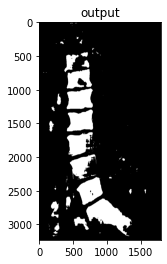

In [ ]:
example = Dataset(data_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/test')

# print(example.lst_input)
# for name in example.lst_input:
#     print(name[:-3])
#     break
# print(example.lst_input.pop(0)[:-3])
# for i in range(20):
#   data = example.__getitem__(i)
#   input = data['input']
#   print(input.shape)

a =np.load('/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/leaderboard/155.npy')
print(a.shape[0]*a.shape[1])
print(a[:,:,6].sum())
print(type(a[0,0,0]))
plt.subplot(111)
plt.imshow(a[:,:,6], cmap='gray')
plt.title('output')

# 이 셀 실행

In [ ]:
test_net = UNET()
test_net.cuda()

optim = torch.optim.Adagrad(test_net.parameters(), lr = 0.01)
test_net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = test_net, optim = optim) # 저장된 네트워크 불러오기

test_trainer_Spine_segment = trainer(test_net, train_loader,"Adagrad", epoch_size=20, learning_rate=0.0001)

test_trainer_Spine_segment.test(test_loader)

1
2
3
4
5
['151.dcm', '152.dcm', '153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3052, 2140)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
1.0
(3052, 2140, 7)
2
3
4
5
['152.dcm', '153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3264, 1852)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
1.0
(3264, 1852, 7)
1
2
3
4
5
['153.dcm', '154.dcm', '155.dcm', '156.dcm', '157.dcm', '158.dcm', '159.dcm', '160.dcm', '181.dcm', '182.dcm', '183.dcm', '184.dcm', '185.dcm', '186.dcm', '187.dcm', '188.dcm', '189.dcm', '190.dcm']
(1, 3228, 1616)
torch.Size([2, 6, 1024, 1024])
torch.Size([6, 1024, 1024])
1.0
(3228, 1616, 7)
2
3
4
5
['154.dcm', '155.dcm', '156.dcm', '157.dcm', '158

# After Train & Test : (Input & label & output) image file save and visualization

(6, 1024, 1024)
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 0. ... 0. 1. 1.]
  [1. 1. 0. ... 0. 0. 1.]
  ...
  [0. 1. 0. ... 1. 1. 1.]
  [1. 1. 0. ... 1. 1. 1.]
  [0. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 0. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [1. 1. 0. ... 0. 0. 1.]
  ...
  [1. 0. 0. ... 1. 1. 1.]
  [1. 0. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 0.]
  [0. 0. 0. ... 1. 1. 0.]
  [1. 0. 0. ... 1. 1. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [1. 1. 0. ... 1. 1. 0.]
  [1. 1. 0. ... 1. 1. 1.]]]


Text(0.5, 1.0, 'output')

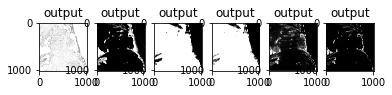

In [ ]:
output = np.load('/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result/numpy/output_0011.npy')

# aaaaa = output[4]
# print(aaaaa)
# classifier = lambda x :  1.0 * (x > 0.5)
# print(np.amin(aaaaa))
# print(np.amax(aaaaa))

# dn = lambda x, min : x - min
# positive = dn(aaaaa, min=np.amin(aaaaa))
# dnn =dn(output[3], max=np.amax(output[3]), min=np.amin(output[3]))


# preds = (output-np.mean(aaaaa))/np.std(aaaaa)
# preds = torch.sigmoid(preds)
# preds = classifier(preds)


print(output.shape)

print(output)


plt.subplot(161)
plt.imshow(output[0], cmap='gray')
plt.title('output')

plt.subplot(162)
plt.imshow(output[1], cmap='gray')
plt.title('output')

plt.subplot(163)
plt.imshow(output[2], cmap='gray')
plt.title('output')

plt.subplot(164)
plt.imshow(output[3], cmap='gray')
plt.title('output')

plt.subplot(165)
plt.imshow(output[4], cmap='gray')
plt.title('output')

plt.subplot(166)
plt.imshow(output[5], cmap='gray')
plt.title('output')





Text(0.5, 1.0, 'output')

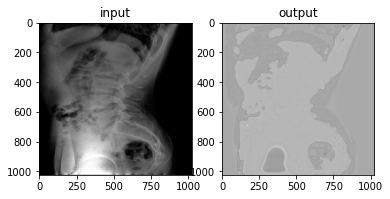

In [ ]:
input = np.load('/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result/numpy/input_0010.npy')
output = np.load('/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result/numpy/output_0010.npy')


plt.subplot(121)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(122)
plt.imshow(output[0],cmap='gray')
plt.title('output')


In [ ]:
result_dir = '/content/drive/MyDrive/21-2/basic_ai/challenge/challenge_dataset/data/result'

lst_data = os.listdir(result_dir)

lst_input = [f for f in lst_data if f.startswith('input')]
lst_label = [f for f in lst_data if f.startswith('label')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_input.sort()
lst_label.sort()
lst_output.sort()

id=0

input = np.load(os.path.join(result_dir, lst_input[id]))
label = np.load(os.path.join(result_dir, lst_label[id]))
output = np.load(os.path.join(result_dir, lst_output[id]))

plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label,cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(result,cmap='gray')
plt.title('result')

IndexError: ignored